# 27. LLM Trend Note 2 [프로젝트_02]
<br>

## 27-1. 프로젝트: KoChatGPT 업그레이드 하기
<br>

#### 필수 requirement 설치 여부 확인
<br>

In [1]:
import torch

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
!pip list | grep transformers # transformers 4.28.0

Torch version:1.12.1
Cuda version: 11.3
transformers                  4.28.0


<br><br>

### Base model and Dataset for RLHF
<br>

In [2]:
# 허깅페이스의 transformers를 사용해 토크나이저와 모델 불러오기

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<br>

In [5]:
# kogpt2 모델의 tokenizer가 입력받아 처리 가능한 최대 토큰 수 확인

In [6]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

<br><br>

### 새로운 데이터셋 추가 (korQuAD 2.0)
<br>

In [7]:
# 데이터셋(korQuAD 2.0) 다운로드
# https://korquad.github.io/

In [46]:
ls /aiffel/aiffel/KoDiag/data_kodiag/

kodiag_1_SFT.xlsx  kodiag_2_RM.xlsx  kodiag_3_POO.xlsx


<br><br>

### 단계별( SFT, RM, PPO) 데이터셋 확인 및 EDA
<br>

#### 01-1 데이터셋(SFT) 확인
<br>

In [11]:
# 데이터 로드

In [51]:
data_path = '/aiffel/aiffel/KoDiag/data_kodiag/kodiag_1_SFT.csv'
df = pd.read_csv(data_path, encoding='CP949')
df

,SPEAKER,SENTENCE,DOMAINID,DOMAIN,CATEGORY,SPEAKERID,SENTENCEID,MAIN,SUB,QA,QACNCT,MQ,SQ,UA,SA,개체명,용어사전,지식베이스,Unnamed: 18
0,고객,지금 배달되나요?,A,음식점,배달음식점,1,1,배달가능문의,NaN,Q,NaN,지금 배달되나요?,NaN,NaN,NaN,"수고, 지금, 배달",NaN,NaN,NaN
1,점원,아 네 배달됩니다,A,음식점,배달음식점,0,2,배달가능문의,NaN,A,NaN,NaN,NaN,NaN,아 네 배달됩니다,배달,NaN,NaN,NaN
2,고객,짬뽕류는 어떤 게 있나요? 잘 나가는 짬뽕 있나요?,A,음식점,배달음식점,1,3,베스트메뉴문의추천요청,NaN,Q,NaN,짬뽕류는 어떤 게 있나요? 잘 나가는 짬뽕 있나요?,NaN,NaN,NaN,짬뽕,NaN,짬뽕/메뉴,NaN
3,점원,특해물 짬뽕도 있고 전복 새우 짬뽕도 있고 해물 종류도 새우 홍합 전복 없는 게 없습니다,A,음식점,배달음식점,0,4,베스트메뉴문의추천요청,NaN,A,NaN,NaN,NaN,NaN,특해물 짬뽕도 있고 전복 새우 짬뽕도 있고 해물 종류도 새우 홍합 전복 없는 게 없습니다,"특해물 짬뽕, 전복 새우 짬뽕, 해물 종류, 새우, 홍합, 전복",NaN,"특해물 짬뽕/메뉴, 전복 새우 짬뽕/메뉴, 새우/해물/재료, 홍합/해물/재료, 전복...",NaN
4,고객,전복 들어가는 거는 특해물 짬뽕 시켜야 돼요?,A,음식점,배달음식점,1,5,메뉴정보문의,NaN,Q,NaN,전복 들어가는 거는 특해물 짬뽕 시켜야 돼요?,NaN,NaN,NaN,"전복, 특해물 짬뽕",NaN,"전복/해물/재료, 특해물 짬뽕/메뉴",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15721,고객,주문하려면 얼마 전에 연락드려야 하나요?,A,음식점,배달음식점,1,919,예약주문문의,NaN,Q,NaN,주문하려면 얼마 전에 연락드려야 하나요?,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15722,고객,이번 목욜 애들 체육대회라 25개 미리 주문하려는데 가능하죠?,A,음식점,배달음식점,1,920,예약주문문의,NaN,Q,NaN,이번 목욜 애들 체육대회라 25개 미리 주문하려는데 가능하죠?,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15723,고객,L 사이즈 면 어느 정도 되는 건가요?,A,음식점,배달음식점,1,921,메뉴사이즈문의,NaN,Q,NaN,L 사이즈 면 어느 정도 되는 건가요?,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15724,고객,탕수육 제일 작은 사이즈는 뭐예요?,A,음식점,배달음식점,1,922,메뉴사이즈문의,NaN,Q,NaN,탕수육 제일 작은 사이즈는 뭐예요?,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br>

In [54]:
conversations = []
for i in range(0, df.shape[0], 2):
    prompt = df.iloc[i]['SENTENCE']
    completion = df.iloc[i+1]['SENTENCE']
    conversations.append([prompt, completion])

In [55]:
# conversations 리스트에는 질문과 대답의 쌍이 저장되어 있습니다.
print(conversations)

[['지금 배달되나요?', '아 네 배달됩니다'], ['짬뽕류는 어떤 게 있나요? 잘 나가는 짬뽕 있나요?', '특해물 짬뽕도 있고 전복 새우 짬뽕도 있고 해물 종류도 새우 홍합 전복 없는 게 없습니다'], ['전복 들어가는 거는 특해물 짬뽕 시켜야 돼요?', '전복 짬뽕 시키면 전복이 들어가죠'], ['전복 들어가고 여러 가지 또 딴 것도 들어가죠?', '네네'], ['마차이 짬뽕밥은 돼지고기 들어가나요?', '짬뽕은 돼지고기 약간씩 들어갑니다'], ['여기 #주소#인데 배달되나요?', '#주소#는 안됩니다'], ['중국집 명성루죠? 배달 지금 가능한가요?', '예 배달 가능합니다'], ['주로 어떤 게 잘 나가요?', '탕수육에 짜장이나 짬뽕 세트가 잘 나가죠 '], ['4인이 먹을 수 있을까요?', '네 명 드시기엔 세트가 양이 적어요 네 명 드시려면 탕수육 중자는 가야죠'], ['중자는 얼마에요?', '중자는 2만 2천 원요'], ['탕수육에 들어가는 고기가 돼지고기죠?', '어느 집이든지 다 돼지고기입니다'], ['그럼 국내산 쓰나요?', '예 돼지고기는 다 국내산입니다'], ['근데 칠리 탕수육도 있고 사천 탕수육도 있던데 어떤 게 나아요?', '학생들은 칠리 좋아하고 일반 어른분들은 일반 탕수육 좋아합니다'], ['그러면 4인 가족이면 탕수육 하나에 딴 거 어떤 거 시켜요?', '짜장면 짬뽕 해물짬뽕 사람마다 좋아하시는 게 다 달라요'], ['해물짬뽕에 어떤 거 들어가요?', '해물 여러 가지 들어가요'], ['예 얼마 정도 해요?', '해물짬뽕 보통 7500원짜리가 있어요'], ['그러면 저희가 이거 지금 주문하면 몇 분 있으면 도착할까요?', '거기 위치가 어디인가요?'], ['침산동 대구일중 근처요', '지금 배달 가능한가요?'], ['네 말씀 하세요', '네 제가 지금 전단지 보고 전화드리는 건데 삼선짬뽕에 들어가는 해물은 어떤 거 있어요?'], ['새우부터 시작해서 여러 가지 들어가요', '얼큰이 짬뽕은 어떤 게 맵기가?'], ['똑같아요

In [56]:
print(len(conversations))

7863


In [57]:
conversations[:1]

[['지금 배달되나요?', '아 네 배달됩니다']]

<br>

#### 01-2 데이터셋(SFT) EDA
<br>

In [58]:
# 문체 분석

In [59]:
# 문체 분류를 위한 기준
def classify_tone(sentence):
    if sentence.endswith('?'):
        return "질문형"
    elif sentence.endswith('.'):
        return "서술형"
    elif sentence.endswith('!'):
        return "감탄형"
    else:
        return "기타"

In [61]:
# 문체 분석
for item in conversations[:3]:
    prompt = item[0]      # 첫 번째 항목은 질문(prompt)입니다.
    completion = item[1]  # 두 번째 항목은 대답(completion)입니다.
    
    # 문체 분류
    prompt_tone = classify_tone(prompt)
    completion_tone = classify_tone(completion)
    
    print(f"Prompt: {prompt} - Tone: {prompt_tone}")
    print(f"Completion: {completion} - Tone: {completion_tone}")
    print("----")

Prompt: 지금 배달되나요? - Tone: 질문형
Completion: 아 네 배달됩니다 - Tone: 기타
----
Prompt: 짬뽕류는 어떤 게 있나요? 잘 나가는 짬뽕 있나요? - Tone: 질문형
Completion: 특해물 짬뽕도 있고 전복 새우 짬뽕도 있고 해물 종류도 새우 홍합 전복 없는 게 없습니다 - Tone: 기타
----
Prompt: 전복 들어가는 거는 특해물 짬뽕 시켜야 돼요? - Tone: 질문형
Completion: 전복 짬뽕 시키면 전복이 들어가죠 - Tone: 기타
----


<br>

In [62]:
# 문장 완성도 분석 (예시: 마지막에 마침표가 있는지로 판단)

In [64]:
# 'prompt'의 완성도 분석
complete_prompts = [item[0] for item in conversations if item[0].endswith('.')]
incomplete_prompts = [item[0] for item in conversations if not item[0].endswith('.')]

# 'completion'의 완성도 분석
complete_completions = [item[1] for item in conversations if item[1].endswith('.')]
incomplete_completions = [item[1] for item in conversations if not item[1].endswith('.')]

In [65]:
print(f"Number of complete prompts: {len(complete_prompts)}")
print(f"Number of incomplete prompts: {len(incomplete_prompts)}")
print(f"Number of complete completions: {len(complete_completions)}")
print(f"Number of incomplete completions: {len(incomplete_completions)}")

Number of complete prompts: 57
Number of incomplete prompts: 7806
Number of complete completions: 126
Number of incomplete completions: 7737


<br>

In [136]:
# 문장의 길이 분포 분석

In [67]:
import matplotlib.pyplot as plt

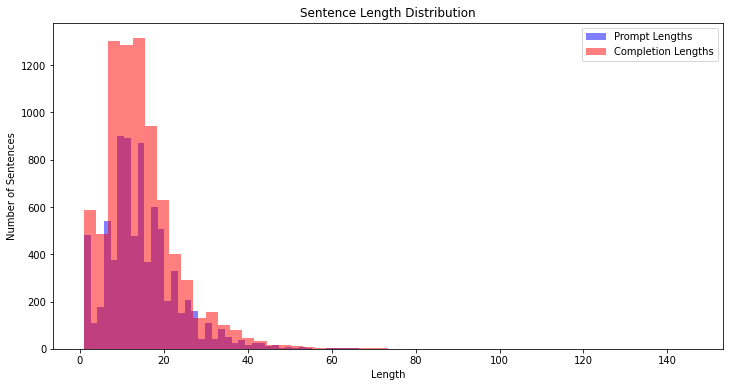

In [69]:
# 'prompt'와 'completion'의 길이를 모두 고려
lengths_prompt = [len(item[0]) for item in conversations]
lengths_completion = [len(item[1]) for item in conversations]

plt.figure(figsize=(12, 6))

# 'prompt' 길이 분포
plt.hist(lengths_prompt, bins=50, color='blue', alpha=0.5, label='Prompt Lengths')

# 'completion' 길이 분포
plt.hist(lengths_completion, bins=50, color='red', alpha=0.5, label='Completion Lengths')

plt.title('Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Sentences')
plt.legend()
plt.show()

In [70]:
print(f"Original data size: {len(conversations)}")

Original data size: 7863


<br>

In [140]:
# 길이 기반 필터링 (지나치게 긴 문장이나 지나치게 짧은 문장을 제거)

In [71]:
MIN_PROMPT_LENGTH = 5
MAX_PROMPT_LENGTH = 40
MIN_COMPLETION_LENGTH = 5
MAX_COMPLETION_LENGTH = 40

In [73]:
filtered_data = [
    item for item in conversations 
    if MIN_PROMPT_LENGTH <= len(item[0]) <= MAX_PROMPT_LENGTH
    and MIN_COMPLETION_LENGTH <= len(item[1]) <= MAX_COMPLETION_LENGTH
]

In [74]:
print(f"Filtered data size: {len(filtered_data)}")

Filtered data size: 6389


<br>

In [75]:
# 중복 제거 ('prompt'와 'completion' 모두를 기반으로 중복 판단)

In [77]:
seen = set()
unique_data = []
for item in filtered_data:
    combined_sentence = item[0] + ' ' + item[1]  # prompt is at index 0 and completion is at index 1
    if combined_sentence not in seen:
        unique_data.append(item)
        seen.add(combined_sentence)

In [78]:
print(f"Unique data size after removing duplicates: {len(unique_data)}")

Unique data size after removing duplicates: 6364


<br>

#### 01-3 데이터셋(SFT) Augmentation
<br>

In [79]:
# nltk에서 wordnet을 사용하기 위해 필요한 데이터 다운로드

In [80]:
import random
import nltk
from nltk.corpus import wordnet

In [81]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /aiffel/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /aiffel/nltk_data...


True

<br>

In [82]:
# Synonym Replacement: 문장 내의 단어를 그 단어의 동의어로 교체

In [83]:
def synonym_replacement(words, n=5):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalnum()]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n: 
            break
    return new_words

In [84]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

<br>

In [85]:
# Random Deletion: 문장 내의 단어를 무작위로 삭제

In [86]:
def random_deletion(words, p=0.5): 
    if len(words) == 1: 
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: 
        return [random.choice(words)]
    else:
        return remaining

<br>

In [87]:
# Random Swap: 문장 내의 두 단어의 위치를 무작위로 바꿈.

In [88]:
def random_swap(sentence, n=5): 
    length = range(len(sentence))
    if len(sentence) < 2:  # Check if the sentence has less than 2 words
        return sentence
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1]
    return sentence

<br>

In [89]:
def augment_sentence(sentence, num_new_sentences=5):
    augmented_sentences = []
    words = sentence.split(' ')
    for _ in range(num_new_sentences):
        if random.uniform(0, 1) < 0.5:
            new_sentence_words = synonym_replacement(words)
        else:
            new_sentence_words = random_swap(words)
        augmented_sentences.append(' '.join(new_sentence_words))
    return augmented_sentences

<br>

In [91]:
augmented_data = []
for item in unique_data:
    augmented_data.append({'prompt': item[0], 'completion': item[1]})
    prompt = item[0]
    completion = item[1]
    for new_prompt in augment_sentence(prompt):
        new_data = {'prompt': new_prompt, 'completion': completion}
        augmented_data.append(new_data)
    for new_completion in augment_sentence(completion):
        new_data = {'prompt': prompt, 'completion': new_completion}
        augmented_data.append(new_data)
    if len(augmented_data) >= 10000:
        break

In [92]:
print(f"Augmented data size: {len(augmented_data)}")

Augmented data size: 10010


<br>

#### 01-4 변경 파일(전처리+증강) 저장
<br>

In [93]:
# 지정된 경로 및 파일명
file_path = '/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kodiag/kodiag_1_SFT_revised.jsonl'

In [94]:
# 파일 쓰기 모드로 파일 열기
with open(file_path, 'w') as f:
    for item in augmented_data:
        f.write(json.dumps(item) + '\n')

<br>

#### 02-1 데이터셋(RM) 확인
<br>

In [219]:
# 데이터 로드

In [220]:
data_path_2_RM = '/aiffel/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

In [221]:
print(len(list_data_dict))

10220


In [222]:
list_data_dict[100:101]

[{'prompt': '요런 줄은 얼만데요?',
  'completion_0': '과일의 급석 경쟁을 토물 한 이유 가라입니다. \n\n- 과일은 변',
  'completion_1': '죄송합니다, 지금 저는 물건을 볼 수 없어서 가격을 알 수 없습니다. 추가정보를 알려주시면 더 도움 드릴 수 있습니다.',
  'completion_2': '이것은 회전 줄입니다.',
  'ranking': [1, 2, 0]}]

<br>

#### 02-2 데이터셋(RM) EDA
<br>

In [223]:
# 문체 분석

In [224]:
# 문체 분류를 위한 기준
def classify_tone(sentence):
    if sentence.endswith('?'):
        return "질문형"
    elif sentence.endswith('.'):
        return "서술형"
    elif sentence.endswith('!'):
        return "감탄형"
    else:
        return "기타"

In [225]:
# 문체 분석
for item in list_data_dict[1000:1002]:
    prompt = item['prompt']
    completions = [item['completion_0'], item['completion_1'], item['completion_2']]
    
    # 문체 분류
    prompt_tone = classify_tone(prompt)
    print(f"Prompt: {prompt} - Tone: {prompt_tone}")
    
    for idx, completion in enumerate(completions, start=1):
        completion_tone = classify_tone(completion)
        print(f"Completion_{idx}: {completion} - Tone: {completion_tone}")
    
    print("----")

Prompt: 요금은 한 시간에 얼마 정도 되나요? - Tone: 질문형
Completion_1: 국방공짜 이상을 한 편의할 효 - Tone: 기타
Completion_2: 한 시간 기준으로 교통 요금은 다르게 책정됩니다. 대부분의 국가에서는 셔틀버스, 버스, 지하철 등의 대중 교통 요금이 1~3 유로 사이로 책정되고 있습니다. 그러나 동서양의 대부분의 도시에서 자동차를 이용하는 경우에는 고객 요구에 따라 한 시간 당 일정 금액 이상의 택시 요금이 발생합니다. - Tone: 서술형
Completion_3: 저는 가상어입니다. 요금은 어떤 것에 대해서냐에 따라 다를 수 있습니다. 추가 문의 사항이 있으시면 구체적으로 말씀해주세요. - Tone: 서술형
----
Prompt: 이명박 대통령과 강만수 장관의 이름을 합성 시킨 단어로 리만 브러더스의 패러디로 탄생한 단어는? - Tone: 질문형
Completion_1: 리만강법(Rimang-GangBeop) - Tone: 기타
Completion_2: The sentence has sentence structure askew. '대통령' is added to the beginning of the sentence to make it sounds more like 'the president'. '문 - Tone: 기타
Completion_3: 리강브로 (Rigangbro) - Tone: 기타
----


<br>

In [226]:
# 문장 완성도 분석 (예시: 마지막에 마침표가 있는지로 판단)

In [227]:
# 'prompt'의 완성도 분석
complete_prompts = [item['prompt'] for item in list_data_dict if item['prompt'].endswith('.')]
incomplete_prompts = [item['prompt'] for item in list_data_dict if not item['prompt'].endswith('.')]

# 'completion'의 완성도 분석
complete_completions_0 = [item['completion_0'] for item in list_data_dict if item['completion_0'].endswith('.')]
incomplete_completions_0 = [item['completion_0'] for item in list_data_dict if not item['completion_0'].endswith('.')]

complete_completions_1 = [item['completion_1'] for item in list_data_dict if item['completion_1'].endswith('.')]
incomplete_completions_1 = [item['completion_1'] for item in list_data_dict if not item['completion_1'].endswith('.')]

complete_completions_2 = [item['completion_2'] for item in list_data_dict if item['completion_2'].endswith('.')]
incomplete_completions_2 = [item['completion_2'] for item in list_data_dict if not item['completion_2'].endswith('.')]

In [228]:
print(f"Number of complete prompts: {len(complete_prompts)}")
print(f"Number of incomplete prompts: {len(incomplete_prompts)}")
print(f"Number of complete completions_0: {len(complete_completions_0)}")
print(f"Number of incomplete completions_0: {len(incomplete_completions_0)}")
print(f"Number of complete completions_1: {len(complete_completions_1)}")
print(f"Number of incomplete completions_1: {len(incomplete_completions_1)}")
print(f"Number of complete completions_2: {len(complete_completions_2)}")
print(f"Number of incomplete completions_2: {len(incomplete_completions_2)}")

Number of complete prompts: 495
Number of incomplete prompts: 9725
Number of complete completions_0: 6404
Number of incomplete completions_0: 3816
Number of complete completions_1: 6399
Number of incomplete completions_1: 3821
Number of complete completions_2: 6429
Number of incomplete completions_2: 3791


<br>

In [229]:
# 문장의 길이 분포 분석

In [230]:
# 'prompt'의 길이 고려
lengths_prompt = [len(item['prompt']) for item in list_data_dict]

# 각 'completion'의 길이 고려
lengths_completion_0 = [len(item['completion_0']) for item in list_data_dict]
lengths_completion_1 = [len(item['completion_1']) for item in list_data_dict]
lengths_completion_2 = [len(item['completion_2']) for item in list_data_dict]

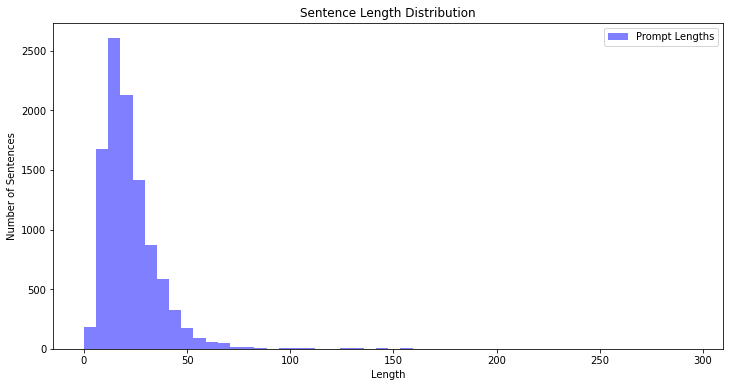

In [231]:
plt.figure(figsize=(12, 6))

# 'prompt' 길이 분포
plt.hist(lengths_prompt, bins=50, color='blue', alpha=0.5, label='Prompt Lengths')

plt.title('Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Sentences')
plt.legend()
plt.show()

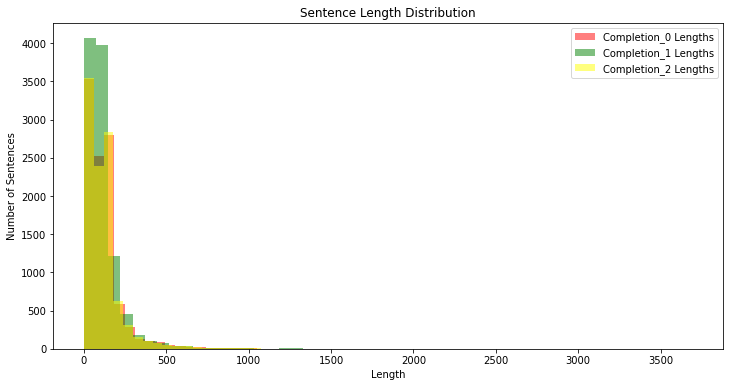

In [232]:
plt.figure(figsize=(12, 6))

# 각 'completion'의 길이 분포
plt.hist(lengths_completion_0, bins=50, color='red', alpha=0.5, label='Completion_0 Lengths')
plt.hist(lengths_completion_1, bins=50, color='green', alpha=0.5, label='Completion_1 Lengths')
plt.hist(lengths_completion_2, bins=50, color='yellow', alpha=0.5, label='Completion_2 Lengths')

plt.title('Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Sentences')
plt.legend()
plt.show()

In [233]:
print(f"Original data size: {len(list_data_dict)}")

Original data size: 10220


<br>

In [234]:
# 길이 기반 필터링 (지나치게 긴 문장이나 지나치게 짧은 문장을 제거)

In [235]:
MIN_PROMPT_LENGTH = 5
MAX_PROMPT_LENGTH = 50
MIN_COMPLETION_LENGTH = 5
MAX_COMPLETION_LENGTH = 300

In [236]:
filtered_data = [
    item for item in list_data_dict 
    if MIN_PROMPT_LENGTH <= len(item['prompt']) <= MAX_PROMPT_LENGTH
    and MIN_COMPLETION_LENGTH <= len(item['completion_0']) <= MAX_COMPLETION_LENGTH
    and MIN_COMPLETION_LENGTH <= len(item['completion_1']) <= MAX_COMPLETION_LENGTH
    and MIN_COMPLETION_LENGTH <= len(item['completion_2']) <= MAX_COMPLETION_LENGTH
]

In [237]:
print(f"Filtered data size: {len(filtered_data)}")

Filtered data size: 8148


<br>

In [238]:
# 중복 제거 ('prompt'와 'completion' 모두를 기반으로 중복 판단)

In [239]:
seen = set()
unique_data = []
for item in filtered_data:
    combined_sentence = item['prompt'] + ' ' + item['completion_0'] + ' ' + item['completion_1'] + ' ' + item['completion_2']
    if combined_sentence not in seen:
        unique_data.append(item)
        seen.add(combined_sentence)

In [240]:
print(f"Unique data size after removing duplicates: {len(unique_data)}")

Unique data size after removing duplicates: 8148


<br>

#### 02-3 데이터셋(RM) Augmentation
<br>

In [241]:
augmented_data = []
for item in filtered_data:
    augmented_data.append(item)
    prompt = item['prompt']
    completion_0 = item['completion_0']
    completion_1 = item['completion_1']
    completion_2 = item['completion_2']

    # For prompt augmentation
    for new_prompt in augment_sentence(prompt):
        new_data = item.copy()
        new_data['prompt'] = new_prompt
        augmented_data.append(new_data)

    # For each completion augmentation
    for new_completion_0 in augment_sentence(completion_0):
        new_data = item.copy()
        new_data['completion_0'] = new_completion_0
        augmented_data.append(new_data)
    
    for new_completion_1 in augment_sentence(completion_1):
        new_data = item.copy()
        new_data['completion_1'] = new_completion_1
        augmented_data.append(new_data)
        
    for new_completion_2 in augment_sentence(completion_2):
        new_data = item.copy()
        new_data['completion_2'] = new_completion_2
        augmented_data.append(new_data)

    if len(augmented_data) >= 1000:
        break

In [242]:
print(f"Augmented data size: {len(augmented_data)}")

Augmented data size: 1008


<br>

#### 02-4 변경 파일(전처리+증강) 저장
<br>

In [243]:
# 지정된 경로 및 파일명
file_path = '/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kodiag/kodiag_2_RM_revised.jsonl'

In [244]:
# 파일 쓰기 모드로 파일 열기
with open(file_path, 'w') as f:
    for item in augmented_data:
        f.write(json.dumps(item) + '\n')

<br>

#### 03-1 데이터셋(POO) 확인
<br>

In [245]:
# 데이터 로드

In [246]:
data_path = '/aiffel/aiffel/KoDiag/data_kodiag/kodiag_3_POO.csv'
df = pd.read_csv(data_path, encoding='CP949')
df

,SPEAKER,SENTENCE,DOMAINID,DOMAIN,CATEGORY,SPEAKERID,SENTENCEID,MAIN,SUB,QA,QACNCT,MQ,SQ,UA,SA,개체명,용어사전,지식베이스,Unnamed: 18
0,고객,삼겹살 1근에 얼마에요?,D,소매,정육점,1,1,가격 문의,NaN,Q,NaN,삼겹살 1근에 얼마에요?,NaN,NaN,NaN,"삼겹살, 1근",NaN,"삼겹살/부위, 1근/중량",NaN
1,점원,만원입니다,D,소매,정육점,0,2,가격 문의,NaN,A,NaN,NaN,NaN,NaN,만원입니다,만원,NaN,만원/금액,NaN
2,고객,넷이 먹을건데 2근이면 되나요?,D,소매,정육점,1,3,0인분 용량 문의,NaN,Q,NaN,넷이 먹을 건데 2근이면 되나요?,NaN,NaN,NaN,"넷, 2근",NaN,"넷/인원, 2근/중량",NaN
3,점원,네 충분하세요,D,소매,정육점,0,4,0인분 용량 문의,NaN,A,NaN,NaN,NaN,NaN,네 충분하세요,NaN,NaN,NaN,NaN
4,고객,그럼 2근주세요,D,소매,정육점,1,5,용량별 고기 주문,NaN,Q,NaN,그럼 2근 주세요,NaN,NaN,NaN,2근,NaN,2근/중량,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14944,고객,이 떡들 다 포장 되어있는거 맞죠?,D,소매,떡집,1,947,포장 상품 구매 확인,NaN,Q,NaN,이 떡들 다 포장 되어있는거 맞죠?,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14945,고객,한 박스로도 포장 되는거죠?,D,소매,떡집,1,948,포장단위 문의,NaN,Q,NaN,한 박스로도 포장 되는거죠?,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14946,고객,박스 말고 그냥 팩 단위로 포장해주실 수 있나요?,D,소매,떡집,1,949,포장단위 문의,NaN,Q,NaN,박스 말고 그냥 팩 단위로 포장해주실 수 있나요?,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14947,고객,포장하는게 너무 커서 좀 적게 포장해주시면 좋을 것 같은데요?,D,소매,떡집,1,950,포장단위 문의,NaN,Q,NaN,포장하는게 너무 커서 좀 적게 포장해주시면 좋을 것 같은데요?,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br>

In [247]:
# 질문을 확인하는 함수
def is_question(sentence):
    return '?' in sentence

In [248]:
# 질문에 해당하는 prompt만 뽑아 리스트에 저장
question_prompts = [sentence for sentence in df['SENTENCE'][::2] if is_question(sentence)]

In [249]:
question_prompts[:5]  # 상위 5개 대화를 출력해 봅니다.

['삼겹살 1근에 얼마에요?',
 '넷이 먹을건데 2근이면 되나요?',
 '살코기 위주로 주시겠어요?',
 '오늘은 어떤 고기가 괜찮아요?',
 '한우인가요?']

In [250]:
print(len(question_prompts))

4184


In [251]:
question_prompts[:1]

['삼겹살 1근에 얼마에요?']

<br>

#### 03-2 데이터셋(POO) EDA
<br>

In [252]:
# 문체 분석

In [253]:
# 문체 분류를 위한 기준
def classify_tone(sentence):
    if sentence.endswith('?'):
        return "질문형"
    elif sentence.endswith('.'):
        return "서술형"
    elif sentence.endswith('!'):
        return "감탄형"
    else:
        return "기타"

In [256]:
# 문체 분석
for prompt in question_prompts[:3]:
    
    # 문체 분류
    prompt_tone = classify_tone(prompt)
    print(f"Prompt: {prompt} - Tone: {prompt_tone}")
    print("----")

Prompt: 삼겹살 1근에 얼마에요? - Tone: 질문형
----
Prompt: 넷이 먹을건데 2근이면 되나요? - Tone: 질문형
----
Prompt: 살코기 위주로 주시겠어요? - Tone: 질문형
----


<br>

In [195]:
# 문장 완성도 분석 (예시: 마지막에 마침표가 있는지로 판단)

In [261]:
# 'prompt'의 완성도 분석
complete_prompts = [prompt for prompt in question_prompts if prompt.endswith('.')]
incomplete_prompts = [prompt for prompt in question_prompts if not prompt.endswith('.')]

In [262]:
print(f"Number of complete prompts: {len(complete_prompts)}")
print(f"Number of incomplete prompts: {len(incomplete_prompts)}")

Number of complete prompts: 22
Number of incomplete prompts: 4162


<br>

In [198]:
# 문장의 길이 분포 분석

In [267]:
lengths_prompt = [len(prompt) for prompt in question_prompts]

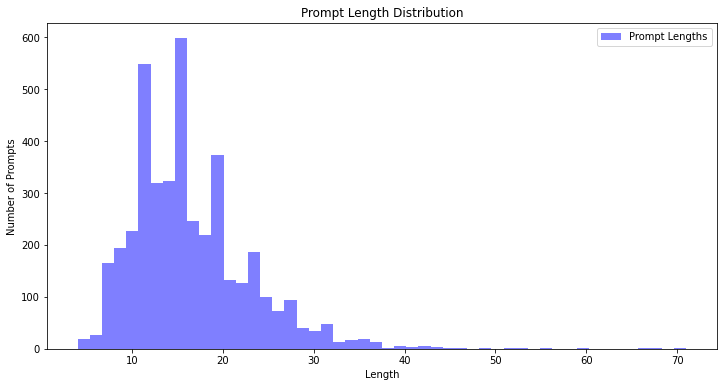

In [268]:
plt.figure(figsize=(12, 6))

plt.hist(lengths_prompt, bins=50, color='blue', alpha=0.5, label='Prompt Lengths')

plt.title('Prompt Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Prompts')
plt.legend()
plt.show()

In [269]:
print(f"Original data size: {len(question_prompts)}")

Original data size: 4184


<br>

In [201]:
# 길이 기반 필터링 (지나치게 긴 문장이나 지나치게 짧은 문장을 제거)

In [270]:
MIN_PROMPT_LENGTH = 5
MAX_PROMPT_LENGTH = 35

In [276]:
filtered_data = [
    item for item in question_prompts
    if MIN_PROMPT_LENGTH <= len(item) <= MAX_PROMPT_LENGTH
]

In [277]:
print(f"Filtered data size: {len(filtered_data)}")

Filtered data size: 4127


<br>

In [278]:
# 중복 제거

In [282]:
seen = set()
unique_data = []
for item in filtered_data:
    if item not in seen:
        unique_data.append(item)
        seen.add(item)

In [283]:
print(f"Unique data size after removing duplicates: {len(unique_data)}")

Unique data size after removing duplicates: 3982


<br>

#### 03-3 데이터셋(POO) Augmentation
<br>

In [284]:
augmented_data = []
for item in unique_data:
    augmented_data.append({'prompt': item[0], 'completion': item[1]})
    prompt = item[0]
    completion = item[1]
    for new_prompt in augment_sentence(prompt):
        new_data = {'prompt': new_prompt, 'completion': completion}
        augmented_data.append(new_data)
    for new_completion in augment_sentence(completion):
        new_data = {'prompt': prompt, 'completion': new_completion}
        augmented_data.append(new_data)
    if len(augmented_data) >= 10000:
        break

In [285]:
print(f"Augmented data size: {len(augmented_data)}")

Augmented data size: 10010


<br>

#### 03-4 변경 파일(전처리+증강) 저장
<br>

In [286]:
# 지정된 경로 및 파일명
file_path = '/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kodiag/kodiag_3_POO_revised.jsonl'

In [287]:
# 파일 쓰기 모드로 파일 열기
with open(file_path, 'w') as f:
    for item in augmented_data:
        f.write(json.dumps(item) + '\n')

<br><br>

### Supervised Fine-Tuning (SFT)
<br>

#### 필요 라이브러리 불러오기
<br>

In [141]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

<br>

#### 모델과 토크나이저 불러오기
<br>

In [142]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')

In [143]:
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

In [144]:
print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


<br>

#### prompt 딕셔너리 템플릿과 SFT 데이터셋 클래스 정의 (모델 인퍼런스 단계에서 사용)
<br>

In [145]:
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        data_path_1_SFT = '/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kodiag/kodiag_1_SFT_revised.jsonl'
        list_data_dict = []
        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            for line in json_file:
                list_data_dict.append(json.loads(line))

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [146]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

<br>

In [147]:
train_dataset = SFT_dataset(data_path_1_SFT='/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kodiag/kodiag_1_SFT_revised.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

In [148]:
print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375, 37770, 28005, 27005, 13675,   375,   378,   378,
          378, 41951,   454,  9549, 20549,   383,  8142,  7192, 14914,  7965,
         9873, 28005,  7255,  7172,  7182,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  7965,
         9873, 28005,  7255,  7172,  7182,     1])


<br>

#### 디코딩 확인
<br>

In [149]:
# 디코딩 함수 작성

In [150]:
def decode_token_ids(token_ids, tokenizer):
    # token_ids를 Python 리스트로 변환
    if isinstance(token_ids, torch.Tensor):
        token_ids = token_ids.tolist()
    
    # token_ids 값을 디코딩
    decoded_text = ""
    for single_token_id in token_ids:
        # -100 값은 무시
        if single_token_id == -100:
            continue
        try:
            decoded_text += tokenizer.decode([single_token_id], skip_special_tokens=True)
        except OverflowError:
            print(f"Problematic token ID: {single_token_id}")
            raise
    
    return decoded_text

<br>

In [151]:
# 주어진 input_ids와 labels를 디코딩하여 출력

In [152]:
input_text = decode_token_ids(train_dataset.input_ids[0], tokenizer)
label_text = decode_token_ids(train_dataset.labels[0], tokenizer)

print('Decoded input:', input_text)
print('Decoded output:', label_text)

Decoded input: ###Instruction(명령어):
지금배달되나요?

###Response(응답):아네배달됩니다
Decoded output: 아네배달됩니다


<br>

#### Training arguments를 사용해 trainer 클래스 정의
<br>

In [153]:
training_args = TrainingArguments(
    output_dir="/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test_newset",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
)

In [154]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

<br>

#### SFT 훈련
<br>

In [155]:
trainer.train()
model.save_pretrained('/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test_newset/output_1_SFT_newset')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,2.729200
1000,1.311100


<br>

#### 문장 생성 능력 확인 (generator 생성)
<br>

In [156]:
generator = pipeline('text-generation', model='/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test_newset/output_1_SFT_newset', tokenizer=tokenizer)

In [157]:
generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375,  
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

In [158]:
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

In [159]:
list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

In [160]:
list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

In [161]:
list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):네 한우는 여기 따로 있습니다 네 불고기 나가는 건 갑니다 저희는 버거 소금 나가요 좀 이렇게 많이

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):1955년생이고요 버거는 킹소세지피자라고 소세지들이 많이 들어가요 저희는 불고기는 나가는 나가고 나가요 피자가 임실 치즈 네

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):2층 이용해 주시면 되세요 불고기는 네 매운 나가는 많이 갑니다 지금 요즘 나가고 치즈 좀 요

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):미세먼지 나갑니다 머스터드 저희 들어간 네 매운 소금 들어가요 가시면 얼음은 많이 요 갑니


<br>

#### 메모리 관리를 위해 캐시 비우기
<br>

In [162]:
torch.cuda.empty_cache()

<br><br>

### Reward Model (RM)
<br>

#### 필요 라이브러리 불러오기
<br>

In [168]:
!rm -rf aiffel/KoChatGPT
!git clone https://github.com/airobotlab/KoChatGPT aiffel/KoChatGPT
!pip install aiffel/KoChatGPT/colossalai_ChatGPT_230319/

Cloning into 'aiffel/KoChatGPT'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 249 (delta 67), reused 97 (delta 51), pack-reused 129
Receiving objects: 100% (249/249), 37.35 MiB | 16.08 MiB/s, done.
Resolving deltas: 100% (97/97), done.
Processing ./aiffel/KoChatGPT/colossalai_ChatGPT_230319
  Preparing metadata (setup.py) ... done
  Created wheel for chatgpt: filename=chatgpt-0.1.0-py3-none-any.whl size=46664 sha256=bd8beda182c350f01acb55c3ff1ffa07daf4ee663dc881e4ea75dd77284a286b
  Stored in directory: /tmp/pip-ephem-wheel-cache-h8uisyuc/wheels/08/cf/7a/9f2d776ec984d54a86f154b095fd76b5eb902ba4eaf667ffbf
Successfully built chatgpt


In [169]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

<br>

#### Reward model 설계
<br>

In [288]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

<br>

#### 사용할 모델과 토크나이저 불러오기
<br>

In [289]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')

In [290]:
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

In [291]:
with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<br>

#### ranking dataset 만들기 (RM 훈련시킬 때 사용)
<br>

In [292]:
list_data_dict = []

with open('/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kodiag/kodiag_2_RM_revised.jsonl', "r", encoding='utf-8-sig') as json_file:
    for line in json_file:
        list_data_dict.append(json.loads(line))

In [293]:
total_data_ranking2chosen = []

for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)

    total_data_ranking2chosen.extend(one_data_ranking2chosen)

In [302]:
print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[70])

before data num: 1008
after  data num: 3024
data example: 
{'prompt': '페르시아로부터 기원된 아랍요리의 특징이 뭐야', 'chosen': '1. 다양한 스파이스와 허브 사용\\n2. 쌀, 콩, 나물, 고기, 양파 등 다양한 재료 사용\\n3. 스위트한 맛과 절임 음식이 많이 사용됨\\n4. 전통적으로 로테이션 방식의 식사로, 다양한 요리들이 함께 제공됨\\n5. 육류 요리 뿐만 아니라 콩이나 채소 기반의 요리도 많이 존재함\\n6. 큰 볼에 담아서 동반되는 파샤워라는 구운 빵\\n7. 타지느라 자원과 식료품이 차고 들쑥날쑥한 중동 지역 상황에 맞게 혹독한 날씨에서도 오래 보존할 수 있는 육류 기술 발전.', 'rejected': '위한 태야 대표 기원들 개인이라 겪고 태야\n\n\n귀식 걸 공개한 구문\n\n사띩의 태야 규정발 한 구문 \n\n사띩은 규정발 한 구문 \n\n사띩은 규정발 한 구문\n\n다시 태야는 구문 \n\n이상 한 구문\n\n다시 태야는 구문'}


<br>

#### 완성한 ranking dataset을 shuffle한 후 훈련셋 만들기
<br>

In [303]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '미스터 허드슨과 팀을 이룬 밴드의 이름은?', 'chosen': '미스터 허드슨과 팀을 이룬 밴드의 이름은 "The Band"입니다.', 'rejected': '앤 허드슨 & McGuire) 머큐리(Hudson'}


<br>

In [304]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

1000
200


In [305]:
train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

100%|██████████| 200/200 [00:00<00:00, 1440.69it/s]


<br>

In [306]:
# 데이터셋이 잘 만들어졌는지 하나를 뽑아 확인

In [307]:
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
원피스의 원래 주인이 누구였어
######################################################################
## chosen ##
?\n\n원피스는 일본의 만화가 오다 에이이치로가 창작한 만화 시리즈입니다. 이 작품에서 원피스라는 것은 신비한 보물을 의미합니다. 따라서 원피스의 "원래 주인"이라는 것은 해당 보물의 소유자를 의미할 것입니다. 원피스에서는 이 보물의 소유자를 찾기 위한 여정이 중심적인 이야기 축으로 다루어지고 있습니다. 당연히, 이러한 보물의 존재는 작품의 세계관 속의 가상의 것이기 때문에, "원래 주인"에 대한 명확한 답변이 존재하지 않습니다.
######################################################################
## rejected ##
요?

원피스의 원래 주인은 핑크 전복 볼몽 소사이어스 롱보우 왕자 (Pirate King Gol D. Roger) 입니다.


<br>

#### RM 학습
<br>

In [309]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [310]:
trainer.fit(use_lora=0)

model.save_pretrained('/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test_newset/output_2_RM_newset')

Train epoch: 100%|██████████| 1/1 [03:58<00:00, 238.64s/it]


<br>

#### RM 학습 여부 확인 (임의의 문장의 입력에 대한 reward score 출력 확인)
<br>

In [311]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

<br>

In [318]:
input_text = '대공황(大恐慌, 영어: Great Depression)은 미국 역사상 가장 길었던 경제위기로[1] 1929년부터 1939년까지 지속되었다.[2] 검은 화요일로 알려진 1929년 월스트리트 대폭락으로 촉발되었다.'
output_reward = inference_RM(input_text=input_text)

input: 대공황(大恐慌, 영어: Great Depression)은 미국 역사상 가장 길었던 경제위기로[1] 1929년부터 1939년까지 지속되었다.[2] 검은 화요일로 알려진 1929년 월스트리트 대폭락으로 촉발되었다.
reward score: 3.3


In [316]:
input_text = '프로그래밍 언어는 컴퓨터 시스템을 구동시키는 소프트웨어를 작성하기 위한 형식언어로서 고급 언어일수록 사람이 사용하는 언어에 가깝습니다.'
output_reward = inference_RM(input_text=input_text)

input: 프로그래밍 언어는 컴퓨터 시스템을 구동시키는 소프트웨어를 작성하기 위한 형식언어로서 고급 언어일수록 사람이 사용하는 언어에 가깝습니다.
reward score: 3.4


In [317]:
input_text = "1957년 10월 4일 소비에트 연방이 세계 최초의 인공위성 스푸트니크 1호의 발사를 성공시킨 것에 의하여 미국은 국민은 자국의 우주 개발 기술이 매우 빈약하다는 사실을 알게 되었다."
output_reward = inference_RM(input_text=input_text)

input: 1957년 10월 4일 소비에트 연방이 세계 최초의 인공위성 스푸트니크 1호의 발사를 성공시킨 것에 의하여 미국은 국민은 자국의 우주 개발 기술이 매우 빈약하다는 사실을 알게 되었다.
reward score: 4.2


In [322]:
input_text = "연합군은 더글러스 맥아더의 9월 15일 인천 상륙 작전을 시작으로 대대적인 반격을 개시하여 10월 10일 평양에 이어 압록강 부근까지 이르렀으나, 11월 중순 중국인민지원군이 개입하여 전세가 다시 뒤집히게 되었으며, 이로 인해 혜산진까지 진격하던 국군은 1951년 1월 4일 서울을 빼앗기고 말았다."
output_reward = inference_RM(input_text=input_text)

input: 연합군은 더글러스 맥아더의 9월 15일 인천 상륙 작전을 시작으로 대대적인 반격을 개시하여 10월 10일 평양에 이어 압록강 부근까지 이르렀으나, 11월 중순 중국인민지원군이 개입하여 전세가 다시 뒤집히게 되었으며, 이로 인해 혜산진까지 진격하던 국군은 1951년 1월 4일 서울을 빼앗기고 말았다.
reward score: 7.2


<br>

#### 메모리 관리를 위해 캐시 비우기
<br>

In [323]:
torch.cuda.empty_cache()

<br><br>

### Proximal Policy Optimization (PPO)
<br>

#### 필요 라이브러리 불러오기
<br>

In [324]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

<br>

#### pretrain 모델인 kogpt-2의 토크나이저를 그대로 사용
<br>

In [325]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test_newset/output_1_SFT_newset', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test_newset/output_2_RM_newset', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

<br>

#### 모델학습에 사용할 옵티마이저와 모델 준비
<br>

In [326]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [327]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

<br>

#### PPO 학습에 쓸 데이터를 불러와 토크나이징
<br>

In [329]:
list_data_dict = []

with open('/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kodiag/kodiag_3_POO_revised.jsonl', "r", encoding='utf-8-sig') as json_file:
    for line in json_file:
        list_data_dict.append(json.loads(line))
        
list_prompt = [tmp['prompt'] for tmp in list_data_dict]

In [330]:
def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [331]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

{'input_ids': tensor([[47311, 10448, 19008,  9792, 11780, 11308, 30190, 10929, 11849, 21663,
         44389,  9574, 13799,   458, 14308, 12778, 22469, 20938, 44696,   458,
         13799,   458, 14308, 12778, 11756, 18944,   389]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [332]:
len(list_prompt)

10010

<br>

#### PPO 학습
<br>

In [333]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

In [334]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test_newset/output_3_PPO_newset')

Episode [10/10]: 100%|██████████| 3/3 [00:20<00:00,  6.82s/it]


<br>

#### RLHF가 적용된 koGPT-2의 생성능력 확인
<br>

In [335]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

In [336]:
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

In [337]:
list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

In [338]:
list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

In [339]:
for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):양념은 어떤 네 돼요?

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):19000원이요 18000원 있어요

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어

### Response(응답):예 저희 주소지가 어떻게 되세요?

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):주세요 개 네 순살은 들어가심


<br><br>

## 27-2. 프로젝트 제출
<br>

### 루브릭
<br>

|<big>평가문항</big>|<big>상세기준</big>|
|:--|:--|
|<br>**1. 기존 데이터셋을 추가 정제하고, generation 성능을 끌어올리기 위한 기법들을 실험해 모델 perfomance를 향상시켜보았는가?**<br><br> | <br>기존 데이터셋의 문제점을 분석하고 전처리 전략을 수립해 추가 정제를 진행했다. Beam search, Top-k(p) sampling 등 최선의 디코딩 전략을 수립해 향상된 모델 추론 결과를 제시했다. BLEU, ROUGE 등 생성된 텍스트를 평가하기 위한 메트릭을 적용한 정량적인 평가 결과와 주관적인 평가를 비교분석하였다.<br><br> |
|<br>**2. 새로운 데이터를 수집해 전처리를 수행하여 모델을 재학습시켜보았는가?**<br><br> | <br>모두의 말뭉치, AI hub 등에 공개된 데이터를 사용해 추가 데이터셋을 구축하기 위한 기준과 근거를 수립했다. ChatGPT API나 다양한 한국어 benchmark 데이터셋을 활용해 Human Feedback 을 대체할 수 있는 아이디어를 구현했다. 위를 바탕으로 SFT, RM, PPO 세 단계에 필요한 각 데이터셋을 적절히 구축하여, 모델 추론 결과와 수립한 가설을 비교해보았다.<br><br> |
|<br>**3. 학습 전략 또는 foundation model을 변경해 모델을 재학습시켜보았는가?**<br><br> | <br>더 적절한 Instruction Tuning 기법을 적용해 SFT를 해보거나, Reward Model의 ranking algorithm을 개선해보았다. KoGPT-2가 아닌 다른 모델을 initial model로 사용하여 모델 학습을 성공시켰다. 허깅페이스의 accelerate, bitsandbytes 라이브러리 등을 사용하여 더 큰 스케일의 모델로 ChatGPT를 re-building해 모델 성능을 향상시켰다.<br><br> |

<br><br>

### 회고
<br>

이 notebooke의 위 내용은 

본 프로젝트의 두 번째 요청사항(위 루브릭의 두 번째 평가문항)에 대한 과제를 수행한 내용으로서

공공 데이터셋 공유 사이트(AI Hub)에 있는 외부 데이터셋을 가져와 새로운 데이터로 

이전과 동일하게 전처리를 수행하여 모델을 재학습시켰으나,

데이터셋의 크기와 text 주제의 한정성 등 때문에 데이터 정제와 augmentation을 통해 

데이터셋을 보완했음에도 실제 성능은 기존의 데이터셋으로 학습시켰을 때보다

많이 좋지 못 했습니다. 이를 통해 데이터셋이 정말 중요하다는 것을 다시 한번 느끼게 되었습니다.